<a href="https://colab.research.google.com/github/lorenzobalzani/bayesian-network-credit-cards/blob/master/bayesian_network_credit_cards_default.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Networks for probabilistic reasoning over credit cards' default
## Project report for the Fundamentals of AI and KR course - module 3
### Authors: [**Lorenzo Balzani**](mailto:lorenzo.balzani@studio.unibo.it) and [**Thomas Guizzetti**](mailto:thomas.guizzetti@studio.unibo.it)

# Abstract
TODO

Left to do: 

- [ ] Calculate inference timing for the models and prove that the most compact model is the most efficient. (Thomas/Lorenzo)
- [x] Apply t-student test to resulting scores of predicting default using the networks and confirm that the results are the same. This means that the networks (and naive bayes learning) in this case don't have much use in predicting default. (lorenzo)
- [x] Get histograms of quesries in the questions (Thomas)
- [ ] Get a result for bias based on sex and default. 

Conclusions:
- Constrained Hill Based model is the model with least bias (default given sex)
- The networks (and naive bayes learning) in this case don't have much use in predicting default. Any predictor based on the bayesian networks is not able to capture the underlying patterns in the data.  
- The TreeSearch networks is the most compact network and thus is the most computationally efficient model. 

# Setup

## Requirements

In [2]:
!pip install -q pandas numpy pgmpy

     |████████████████████████████████| 1.9 MB 30.2 MB/s 


## Imports

In [3]:
from __future__ import annotations # for type annotations
import os, logging
import pandas as pd

#pygmpy
from pgmpy.base import DAG
from pgmpy.models import BayesianNetwork, NaiveBayes
from pgmpy.factors.discrete.CPD import TabularCPD
from pgmpy.inference import VariableElimination
from pgmpy.estimators import ParameterEstimator, MaximumLikelihoodEstimator, BayesianEstimator, ExhaustiveSearch, TreeSearch, HillClimbSearch, MmhcEstimator, BDeuScore, BicScore
from pgmpy.metrics import correlation_score, log_likelihood_score, structure_score

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, f1_score, accuracy_score

# Viz
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

# Math
import numpy as np
from scipy.stats import norm

## Declarations

In [4]:
logger = logging.getLogger()
dataset_url = 'https://raw.githubusercontent.com/lorenzobalzani/bayesian-network-credit-cards/master/dataset.csv'
test_ratio = 0.2
random_seed = 42
print_bold = lambda string: print('\033[1m' + string + '\033[0m')

# Dataset

In [5]:
def read_dataset(url: str) -> pd.DataFrame:
  dataset = pd.read_csv(url, delimiter=';').set_index('ID') \
            .rename(columns={'default payment next month': 'default'})
  return dataset.drop(columns=[column for column in dataset.columns if 'AMT' in column]) \
         .rename(columns={column: column.lower() for column in dataset.columns})

dataset = read_dataset(dataset_url)
# display the dataset

## Check for missing values
No drops are needed here because the dataset is complete.

In [6]:
np.sum(pd.isnull(dataset), axis=0) # sum over the columns

limit_bal    0
sex          0
education    0
marriage     0
age          0
pay_1        0
pay_2        0
pay_3        0
pay_4        0
pay_5        0
pay_6        0
default      0
dtype: int64

## Distribution of `limit_bal` 
First, we print out the histogram related to the distribution of `limit_bal`, which is the only continuous variable used.

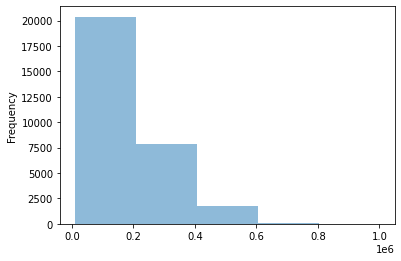

In [7]:
ax = dataset['limit_bal'].plot.hist(bins=5, alpha=0.5)

Next, we describe the distribution. To discretize it, we would like to create four beams (i.e., corresponding to the four percentiles).

In [8]:
dataset['limit_bal'].describe()

count      30000.000000
mean      167484.322667
std       129747.661567
min        10000.000000
25%        50000.000000
50%       140000.000000
75%       240000.000000
max      1000000.000000
Name: limit_bal, dtype: float64

## Manipulation
The *artificial column* `misspayments_prev_6_months` can hold either positive, negative numbers or 0. In particular, this means: 
1. $ n = -2 $ corresponds to there was no credit to pay;
2. $ n = -1 $ corresponds to payed successfully;
3. $ n = 0 $ corresponds to a payment that was made on time but not totally to clear the balance (i.e., the minimum payment was met);
4. $ n > 0 $ corresponds to the number of delayed months.

All computations - but `misspayments_prev_6_months` - are performed in a vectorized fashion using NumPy. The less efficient alternative would have used the `apply` method over Pandas DataFrame, which internally leverages a for loop.

In [9]:
%%time

def manipulate_dataset(df: pd.DataFrame) -> pd.DataFrame:
  compute_misspayments = lambda payments_status: sum([payment_status > 0 for payment_status in payments_status])
  df['sex'] = np.where(df['sex'] == 1, 'male', 'female')
  df['marriage'] = np.where(df['marriage'] == 1, 'married', 'not_married')
  df['age'] = np.select([
              (df['age'] < 35), 
              (df['age'] >= 35) & (df['age'] < 60)],
              ['young', 'mid_aged'], default = 'senior')
  df['limit_bal'] = np.select([
                    (df['limit_bal'] < 50_000), 
                    (df['limit_bal'] >= 50_000) & (df['limit_bal'] < 140_000),
                    (df['limit_bal'] >= 140_000) & (df['limit_bal'] < 240_000)],
                    ['low', 'medium', 'medium_high'], default = 'high')
  df['education'] = np.select([
                    (df['education'] == 1), 
                    (df['education'] == 2), 
                    (df['education'] == 3)], 
                    ['graduate', 'university', 'high_school'], default = 'others') 
  df['misspayments_prev_6_months'] = df.apply(lambda row: \
                                              compute_misspayments([row[column] for column in df.columns if 'pay_' in column]), 
                                              axis=1) #axis = 1 means row by row
  return df.drop(columns=[column for column in df.columns if 'pay_' in column])

dataset = manipulate_dataset(read_dataset(dataset_url))

CPU times: user 750 ms, sys: 20.1 ms, total: 770 ms
Wall time: 809 ms


In [10]:
print(f'The dataset contains {dataset.shape[0]} rows, {dataset.shape[1]} columns and it weighs {(dataset.memory_usage(index=True, deep=True).sum() / 10**6):.2f}MB')
dataset.head()

The dataset contains 30000 rows, 7 columns and it weighs 10.37MB


,limit_bal,sex,education,marriage,age,default,misspayments_prev_6_months
ID,,,,,,,
1,low,female,university,married,young,1,2
2,medium,female,university,not_married,young,1,2
3,medium,female,university,not_married,young,0,0
4,medium,female,university,married,mid_aged,0,0
5,medium,male,university,married,mid_aged,0,0


## States
TBC: Description of final dataset and its values
List - for each variable - the associated states, i.e. every possibile unique value in the domain $D$ of a random variable.

In [11]:
{col_name: column.unique() for col_name, column in dataset.iteritems()}

{'limit_bal': array(['low', 'medium', 'high', 'medium_high'], dtype=object),
 'sex': array(['female', 'male'], dtype=object),
 'education': array(['university', 'graduate', 'high_school', 'others'], dtype=object),
 'marriage': array(['married', 'not_married'], dtype=object),
 'age': array(['young', 'mid_aged', 'senior'], dtype=object),
 'default': array([1, 0]),
 'misspayments_prev_6_months': array([2, 0, 1, 4, 5, 6, 3])}

## Train/test splitting

In [12]:
X_train, X_test, y_train, y_test = train_test_split(dataset.drop('default', axis=1), dataset['default'], \
                                                    test_size=test_ratio, random_state=random_seed, \
                                                    stratify=dataset['default'])
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)
print("Training set size: " + str(train.shape[0]))
print("Test set size: " + str(test.shape[0]))
print("Total size: " + str(train.shape[0] + test.shape[0]))

Training set size: 24000
Test set size: 6000
Total size: 30000


# Utility functions

## Plotting networks

In [13]:
def plot_network(network: 'DAG', name: str = 'Network', save_image: bool = False):
  fig, ax = plt.subplots(1, 1, figsize=(12, 12))
  nx.draw_networkx(network, pos=nx.drawing.layout.circular_layout(network), ax=ax, node_size=5000)
  ax.set_title(name)
  if save_image:
    fig.savefig(name)

## Parameter learning (CDPs)
Parameter are estimated given an already-defined $DAG = \{V, E\}$. The estimation is related to every random variable's *CPT*.

In [14]:
def fit_bayesian_network(bayesian_network: BayesianNetwork, prior_type: str = 'BDeu', print_cpd: bool = False) -> tuple[BayesianNetwork, list]:
  bayesian_network.fit(train, estimator=BayesianEstimator, prior_type = prior_type)
  print('The CPDs contain', 'no' if bayesian_network.check_model() else 'some', 'errors.')
  bn_cpds = bayesian_network.get_cpds()
  if print_cpd:
    TabularCPD._truncate_strtable = lambda self, x: x
    for cpd in bn_cpds:
      print(cpd)
  return bayesian_network, bn_cpds

# Hard-coded networks

## Easy

The CPDs contain no errors.


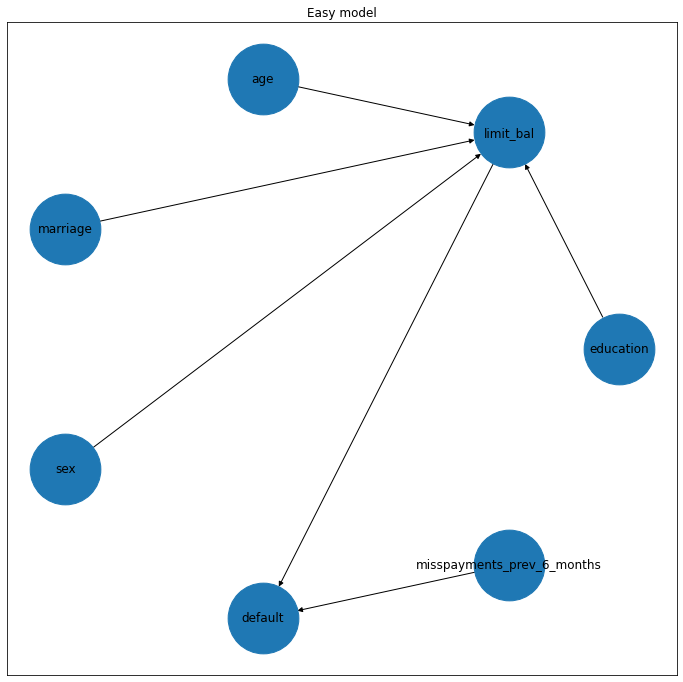

In [15]:
model_easy = BayesianNetwork([('education', 'limit_bal'), ('age', 'limit_bal'), \
                       ('marriage', 'limit_bal'), ('sex', 'limit_bal'), \
                       ('limit_bal', 'default'), ('misspayments_prev_6_months', 'default')])
plot_network(model_easy, 'Easy model')
model_easy, model_easy_cpds = fit_bayesian_network(model_easy, prior_type = 'BDeu', print_cpd = False)

## Medium

The CPDs contain no errors.


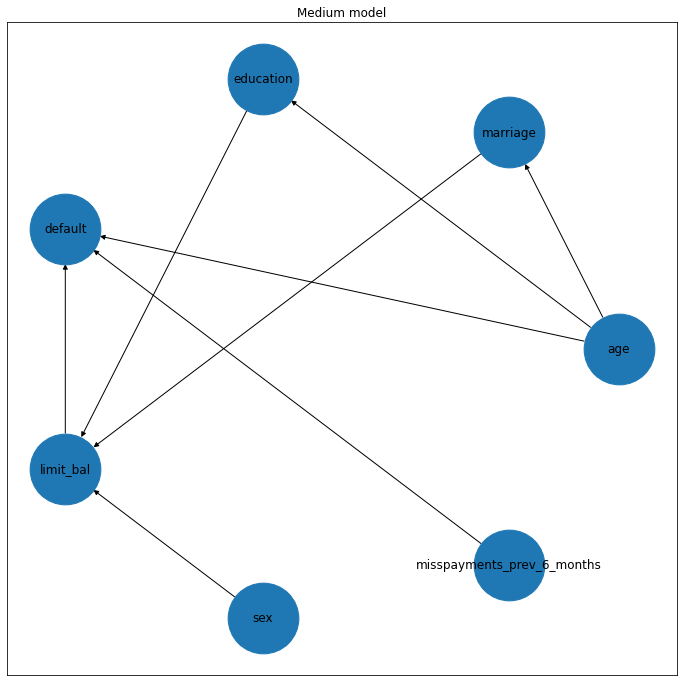

In [16]:
model_medium = BayesianNetwork([("age", "marriage"), ("age", "education"), \
                       ("age", "education"),("age", "default"), \
                       ("education", "limit_bal"), ("marriage", "limit_bal"), \
                       ("limit_bal", "default"), ("sex", "limit_bal"), \
                       ("misspayments_prev_6_months", "default")])
plot_network(model_medium, 'Medium model')
model_medium, model_medium_cpds = fit_bayesian_network(model_medium, prior_type = 'BDeu', print_cpd = False)

## Hard

The CPDs contain no errors.


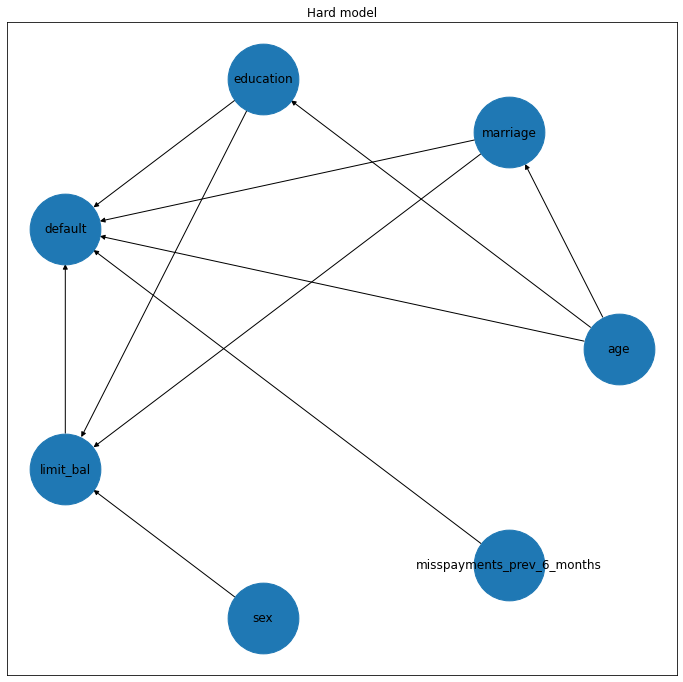

In [17]:
model_hard = BayesianNetwork([("age", "marriage"), ("age", "education"), \
                       ("age", "education"),("age", "default"), \
                       ("education", "limit_bal"), ("marriage", "limit_bal"), \
                       ("limit_bal", "default"), ("sex", "limit_bal"), \
                       ("misspayments_prev_6_months", "default"), ("education", "default"), \
                       ("marriage", "default")])
plot_network(model_hard, 'Hard model')
model_hard, model_hard_cpds = fit_bayesian_network(model_hard, prior_type = 'BDeu', print_cpd = False)

# Structural-learned models
Since query results are poor when comparing the three different models, there is likely no difference betwee the three represetations and thus, we should seek a different model structure.

## Exhaustive Search
Since the ES algorithm cost is super-exponential, it's suited only for small BN, i.e. for networks having less than 5 nodes. In our case, this method is computationally inadequate so will not be included in the networks. 

In [18]:
#ex_search = ExhaustiveSearch(data=train, scoring_method=BicScore(data=train))
#ex_search_model = ex_search.estimate()
#plot_network(ex_search_model, 'Structural Learning - Exhaustive search')
#ex_search_model = BayesianNetwork(ex_search_model.edges())
#ex_search_model, ex_search_model_cpds = fit_bayesian_network(ex_search_model, prior_type = 'BDeu', print_cpd = False)

## Tree Search

Building tree:   0%|          | 0/21.0 [00:00<?, ?it/s]

The CPDs contain no errors.


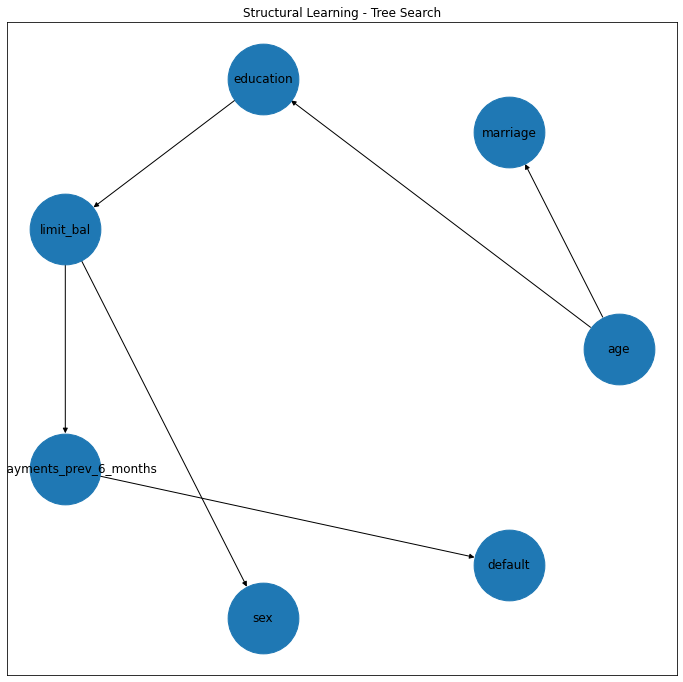

In [19]:
ts = TreeSearch(data=train, root_node='age')
tree_search_model = ts.estimate(show_progress=True)
plot_network(tree_search_model, 'Structural Learning - Tree Search')
tree_search_model = BayesianNetwork(tree_search_model.edges())
tree_search_model, tree_search_cpds = fit_bayesian_network(tree_search_model, prior_type = 'BDeu', print_cpd = False)

## Hill Climb

  0%|          | 0/1000000 [00:00<?, ?it/s]

The CPDs contain no errors.


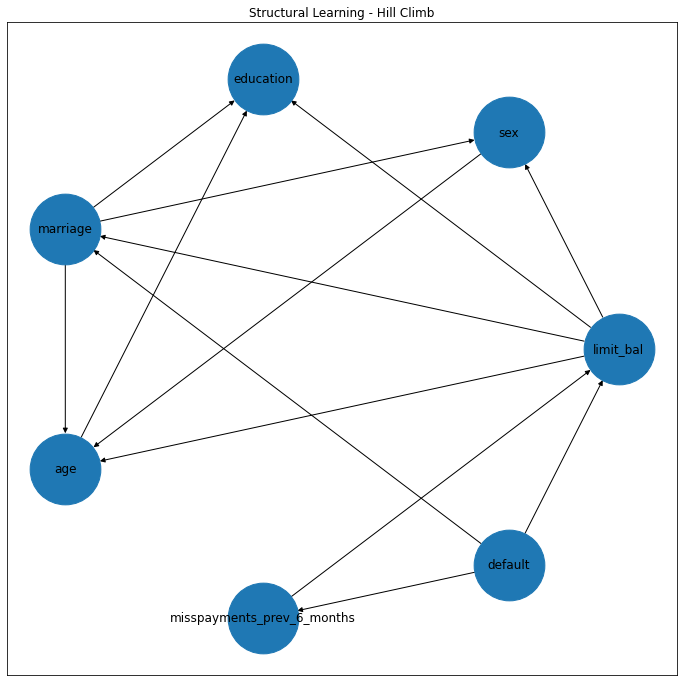

In [20]:
hill_climb = HillClimbSearch(data=train)
hill_climb_base_model = hill_climb.estimate(scoring_method=BDeuScore(data=train), show_progress=True)
plot_network(hill_climb_base_model, 'Structural Learning - Hill Climb')
hill_climb_base_model = BayesianNetwork(hill_climb_base_model.edges())
hill_climb_base_model, hill_climb_base_cpds = fit_bayesian_network(hill_climb_base_model, prior_type = 'BDeu', print_cpd = False)

## Constrained Hill Climb

  0%|          | 0/1000000 [00:00<?, ?it/s]

The CPDs contain no errors.


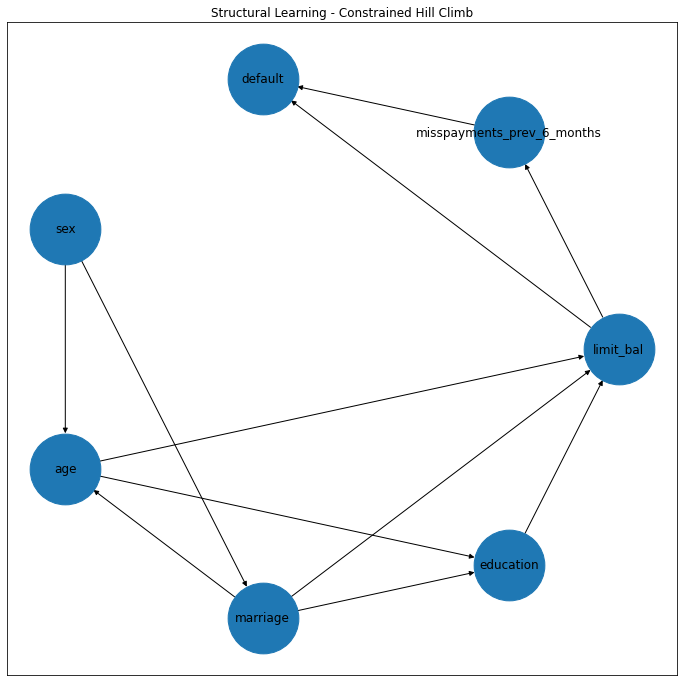

In [21]:
edges_white_list = [('misspayments_prev_6_months', 'default'), ('age','limit_bal')]
edges_black_list = [('limit_bal', 'sex'), ('education', 'sex'), ('age', 'sex')]

hill_climb = HillClimbSearch(data=train)
constr_hill_climb_model = hill_climb.estimate(scoring_method=BDeuScore(data=train), fixed_edges=edges_white_list, \
                                              black_list=edges_black_list, show_progress=True)
constr_hill_climb_model = BayesianNetwork(constr_hill_climb_model.edges())
plot_network(constr_hill_climb_model, 'Structural Learning - Constrained Hill Climb')
constr_hill_climb_model, hill_climb_constr_cpds = fit_bayesian_network(constr_hill_climb_model, prior_type = 'BDeu', print_cpd = False)

# Network analysis

We now have six differently designed Bayesian Networks with CPDs. Let's use the Pgmpy library to explore the local semantics or the networks and their Markov Blankets.

In [22]:
models = {'model_easy': model_easy, 
          'model_medium': model_medium, 
          'model_hard': model_hard, 
          'tree_search_model': tree_search_model, 
          'hill_climb_base_model': hill_climb_base_model, 
          'constr_hill_climb_model': constr_hill_climb_model}
          
nodes = [col_name for col_name, column in dataset.iteritems()]

for model_name in models:
  print_bold(os.linesep + model_name + os.linesep)
  print_bold('Local semantics:')
  print(models[model_name].local_independencies(nodes))
  print_bold('Markov Blankets:')
  for node in nodes:
    print(f'Markov blanket of node {node}:', str(models[model_name].get_markov_blanket(node)))


model_easy

Local semantics:
(limit_bal ⟂ misspayments_prev_6_months | sex, age, marriage, education)
(sex ⟂ age, marriage, misspayments_prev_6_months, education)
(education ⟂ sex, age, marriage, misspayments_prev_6_months)
(marriage ⟂ sex, age, misspayments_prev_6_months, education)
(age ⟂ sex, marriage, misspayments_prev_6_months, education)
(default ⟂ sex, age, marriage, education | limit_bal, misspayments_prev_6_months)
(misspayments_prev_6_months ⟂ sex, age, marriage, limit_bal, education)
Markov Blankets:
Markov blanket of node limit_bal: ['sex', 'age', 'misspayments_prev_6_months', 'marriage', 'default', 'education']
Markov blanket of node sex: ['age', 'marriage', 'limit_bal', 'education']
Markov blanket of node education: ['sex', 'age', 'marriage', 'limit_bal']
Markov blanket of node marriage: ['sex', 'age', 'limit_bal', 'education']
Markov blanket of node age: ['sex', 'marriage', 'limit_bal', 'education']
Markov blanket of node default: ['limit_bal', 'misspayments_prev_6_mont

Let's see how the three characterising types of a Bayesian Network (common parent, cascade and V-structure) impact indipendencies within the networks.

__Common parent__:

In TREE SEARCH, we have that _marriage_ <- _age_ -> _education_. Hence we say that _age_ is a common parent to _marriage_ and _education_. Let's visualise the independencies that it generates:

In [23]:
print(tree_search_model.local_independencies(['age', 'marriage', 'education']))

(marriage ⟂ sex, misspayments_prev_6_months, limit_bal, default, education | age)
(education ⟂ marriage | age)


This shows how education and marriage are indipendent given age, which is indeed a result given by their structure in the network. Moreover, we can see that since _age_ is the only node in the Markov Blanket of _marriage_, the latter is indeed indipendent to the rest of the network given _age_.

__Cascade__:

In TREE SEARCH, we have that _age_ -> _education_ -> _limit-bal_ is a cascade. Let's visualise the independencies that it generates:

In [24]:
print(tree_search_model.local_independencies(['age', 'education', 'limit_bal']))

(education ⟂ marriage | age)
(limit_bal ⟂ age, marriage | education)


This shows that given _education_, _age_ and _limit-bal_ are independent, which is again a given in a cascade structure. 

__V-structure__:

In EASY, we can see that _limit-bal_ -> _default_ <- _misspayment-prev-6-months_. We call this a V-structure. Let's visualise once again the independencies generated: 

In [25]:
print(model_easy.local_independencies(['limit_bal', 'default', 'misspayments_prev_6_months']))

(limit_bal ⟂ misspayments_prev_6_months | sex, age, marriage, education)
(default ⟂ sex, age, marriage, education | limit_bal, misspayments_prev_6_months)
(misspayments_prev_6_months ⟂ sex, age, marriage, limit_bal, education)


We can see already that _limit-bal_ is independent to _misspayment-prev-6-months_ when default is not observed. Let's now formalise this a little by proving the below independence relationship:

* P(_limit-bal_ AND _misspayments_prev_6_months_) = P(_limit-bal_) * P(_misspayments_prev_6_months_)

* P(_limit-bal_ AND _misspayments_prev_6_months_ | _default_) != P(_limit-bal_ | _default_) * P(_misspayments-prev-6-months_ | _default_)


In [26]:
print("P(limit-bal AND misspayments-prev-6-months) = P(limit-bal) * P(misspayments_prev_6_months) is " + \
      str(VariableElimination(model_easy).query(["misspayments_prev_6_months", "limit_bal"]) == \
      VariableElimination(model_easy).query(["limit_bal"]) * VariableElimination(model_easy).query(["misspayments_prev_6_months"])))

print("P(limit-bal AND misspayments-prev-6-months | default) = P(limit-bal | default) * P(misspayments_prev_6_months | default) is " + \
      str(VariableElimination(model_easy).query(["misspayments_prev_6_months", "limit_bal"], {"default":0}) == \
      VariableElimination(model_easy).query(["limit_bal"], {"default":0}) * VariableElimination(model_easy).query(["misspayments_prev_6_months"], {"default":0})))

P(limit-bal AND misspayments-prev-6-months) = P(limit-bal) * P(misspayments_prev_6_months) is True
P(limit-bal AND misspayments-prev-6-months | default) = P(limit-bal | default) * P(misspayments_prev_6_months | default) is False


Indeed we have that limit_bal is independent to misspayments_prev_6_months when default is not observed, while limit_bal is conditionally dependent to misspayments_prev_6_months when default is observed.

__Compactness__

Which model is more compact?

_EASY_: Number of parameters required to describe CPDs = 1 + 1 + 3 + 2 + 144 + 6 + 28 = 185

_MEDIUM_: Number of parameters required to describe CPDs > 185

_HARD_: Number of parameters required to describe CPDs > 185

_TREE SEARCH_: Number of parameters required to describe CPDs = 2 + 3 + 9 + 12 + 
4 + 24 + 7 = 61

_HILL CLIMB_: Number of parameters required to describe CPDs > 61

_CONSTRAINED HILL CLIMB_: Number of parameters required to describe CPDs > 61

So we have that the Tree Search is the most compact network. 

In [89]:
data_infer_easy = VariableElimination(model_easy)
data_infer_medium = VariableElimination(model_medium)
data_infer_hard = VariableElimination(model_hard)
data_infer_tree_search = VariableElimination(tree_search_model)
data_infer_hill_climb = VariableElimination(hill_climb_base_model)
data_infer_constr_hill_climb = VariableElimination(constr_hill_climb_model)

data_infer_model = [[model_easy, 'model_easy'], [model_medium, 'model_medium'], [model_hard, 'model_hard'], [tree_search_model, 'tree_search_model'], \
                    [hill_climb_base_model, 'hill_climb_base_model'], [constr_hill_climb_model, 'constr_hill_climb_model']]


query, evidence = ["default"], {"age": "young"}

import timeit

def query_function(model, query, evidence):
    data_infer = VariableElimination(model)
    return data_infer.query(query, evidence)

loop = 5000

#result = []
#print("The runtime for the query for model_easy is: " + str(timeit.timeit('query_function(model_easy, query, evidence)', globals=globals(), number=loop)))
#print()
#print("The runtime for the query for model_medium is: " + str(timeit.timeit('query_function(model_medium, query, evidence)', globals=globals(), number=loop)))
#print()
#print("The runtime for the query for model_hard is: " + str(timeit.timeit('query_function(model_hard, query, evidence)', globals=globals(), number=loop)))
#print()
#print("The runtime for the query for tree_search_model is: " + str(timeit.timeit('query_function(tree_search_model, query, evidence)', globals=globals(), number=loop)))
#print()
#print("The runtime for the query for hill_climb_base_model is: " + str(timeit.timeit('query_function(hill_climb_base_model, query, evidence)', globals=globals(), number=loop)))
#print()
#print("The runtime for the query for constr_hill_climb_model is: " + str(timeit.timeit('query_function(constr_hill_climb_model, query, evidence)', globals=globals(), number=loop)))#




In [83]:
%%timeit -r  -n 1000
query_function(model_easy, query, evidence)

1.97 ms ± 524 µs per loop (mean ± std. dev. of 10 runs, 1000 loops each)


In [84]:
%%timeit -r 10 -n 1000
query_function(model_medium, query, evidence)

1.63 ms ± 132 µs per loop (mean ± std. dev. of 10 runs, 1000 loops each)


In [85]:
%%timeit -r 10 -n 1000
query_function(model_hard, query, evidence)

1.6 ms ± 118 µs per loop (mean ± std. dev. of 10 runs, 1000 loops each)


In [86]:
%%timeit -r 10 -n 1000
query_function(tree_search_model, query, evidence)

1.3 ms ± 33.3 µs per loop (mean ± std. dev. of 10 runs, 1000 loops each)


In [87]:
%%timeit -r 10 -n 1000
query_function(hill_climb_base_model, query, evidence)

1.46 ms ± 61.3 µs per loop (mean ± std. dev. of 10 runs, 1000 loops each)


In [88]:
%%timeit -r 10 -n 1000
query_function(constr_hill_climb_model, query, evidence)

1.64 ms ± 31.5 µs per loop (mean ± std. dev. of 10 runs, 1000 loops each)


# Queries
* P(Default | age) 
* P(Default | age, marriage)
* P(Default | age, marriage, education)
* P(Education = graduate | default)
* P(Default | Education = graduate, Misspayment = 5)
* P(Default | Education = High school, Misspayment = 5)

*TBC: Explain why we're using variable elimination (Optional, construct algorigthm instead of using class)*

In [ ]:
data_infer_easy = VariableElimination(model_easy)
data_infer_medium = VariableElimination(model_medium)
data_infer_hard = VariableElimination(model_hard)
data_infer_tree_search = VariableElimination(tree_search_model)
data_infer_hill_climb = VariableElimination(hill_climb_base_model)
data_infer_constr_hill_climb = VariableElimination(constr_hill_climb_model)

def display_inference_results(query_desc: str, query: list, evidence: dict):
  print_bold(query_desc)
  print_bold('EASY')
  print(data_infer_easy.query(query, evidence))
  print_bold('MEDIUM')
  print(data_infer_medium.query(query, evidence))
  print_bold('HARD')
  print(data_infer_hard.query(query, evidence))
  print_bold('TREE SEARCH')
  print(data_infer_tree_search.query(query, evidence))
  print_bold('HILL CLIMB')
  print(data_infer_hill_climb.query(query, evidence))
  print_bold('CONSTRAINED HILL CLIMB')
  print(data_infer_constr_hill_climb.query(query, evidence))

In [ ]:
query, evidence = ["default"], {"age": "young"}
display_inference_results('Probability of default being young', query, evidence)

Probability of default being young
EASY
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7757 |
+------------+----------------+
| default(1) |         0.2243 |
+------------+----------------+
MEDIUM
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7898 |
+------------+----------------+
| default(1) |         0.2102 |
+------------+----------------+
HARD
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7894 |
+------------+----------------+
| default(1) |         0.2106 |
+------------+----------------+
TREE SEARCH
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7804 |
+------------+----------------+
| default(1) |         0.2196 |
+------------+----------------+
HILL CLIMB
+------------+---------------

In [ ]:
query, evidence = ["default"], {"age": "mid_aged"}
display_inference_results('Probability of default being mid aged', query, evidence)

Probability of default being mid aged
EASY
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7818 |
+------------+----------------+
| default(1) |         0.2182 |
+------------+----------------+
MEDIUM
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7650 |
+------------+----------------+
| default(1) |         0.2350 |
+------------+----------------+
HARD
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7665 |
+------------+----------------+
| default(1) |         0.2335 |
+------------+----------------+
TREE SEARCH
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7770 |
+------------+----------------+
| default(1) |         0.2230 |
+------------+----------------+
HILL CLIMB
+------------+------------

In [ ]:
query, evidence = ["default"], {"age": "senior"}
display_inference_results('Probability of default being mid senior', query, evidence)

Probability of default being mid senior
EASY
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7810 |
+------------+----------------+
| default(1) |         0.2190 |
+------------+----------------+
MEDIUM
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7512 |
+------------+----------------+
| default(1) |         0.2488 |
+------------+----------------+
HARD
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7370 |
+------------+----------------+
| default(1) |         0.2630 |
+------------+----------------+
TREE SEARCH
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7750 |
+------------+----------------+
| default(1) |         0.2250 |
+------------+----------------+
HILL CLIMB
+------------+----------

In [ ]:
query, evidence = ["default"], {"age": "mid_aged", "marriage": "not_married"}
display_inference_results('Probability of default being mid aged and married', query, evidence)

Probability of default being mid aged and married
EASY
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7796 |
+------------+----------------+
| default(1) |         0.2204 |
+------------+----------------+
MEDIUM
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7579 |
+------------+----------------+
| default(1) |         0.2421 |
+------------+----------------+
HARD
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7680 |
+------------+----------------+
| default(1) |         0.2320 |
+------------+----------------+
TREE SEARCH
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7770 |
+------------+----------------+
| default(1) |         0.2230 |
+------------+----------------+
HILL CLIMB
+------------+

In [ ]:
query, evidence = ["default"], {"age": "mid_aged", "marriage": "married", "education": "graduate"}
display_inference_results('Probability of default being mid aged and married and holding a graduate degree', query, evidence)

Probability of default being mid aged and married and holding a graduate degree
EASY
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7970 |
+------------+----------------+
| default(1) |         0.2030 |
+------------+----------------+
MEDIUM
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7847 |
+------------+----------------+
| default(1) |         0.2153 |
+------------+----------------+
HARD
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7794 |
+------------+----------------+
| default(1) |         0.2206 |
+------------+----------------+
TREE SEARCH
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7948 |
+------------+----------------+
| default(1) |         0.2052 |
+------------+-------------

In [ ]:
query, evidence = ["education"], {"default": 1}
display_inference_results('Probabilities of holding education titles having had the default', query, evidence)

Probabilities of holding education titles having had the default
EASY
+------------------------+------------------+
| education              |   phi(education) |
+========================+==================+
| education(graduate)    |           0.3334 |
+------------------------+------------------+
| education(high_school) |           0.1712 |
+------------------------+------------------+
| education(others)      |           0.0158 |
+------------------------+------------------+
| education(university)  |           0.4796 |
+------------------------+------------------+
MEDIUM
+------------------------+------------------+
| education              |   phi(education) |
+========================+==================+
| education(graduate)    |           0.3308 |
+------------------------+------------------+
| education(high_school) |           0.1745 |
+------------------------+------------------+
| education(others)      |           0.0158 |
+------------------------+------------------+
| e

In [ ]:
query, evidence = ["default"], {"education": "graduate", "misspayments_prev_6_months": 5}
display_inference_results('Probability of default holding a graduate degree and having 5 misspayments in the previous 6 months', query, evidence)

Probability of default holding a graduate degree and having 5 misspayments in the previous 6 months
EASY
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.4177 |
+------------+----------------+
| default(1) |         0.5823 |
+------------+----------------+
MEDIUM
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.4228 |
+------------+----------------+
| default(1) |         0.5772 |
+------------+----------------+
HARD
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.5804 |
+------------+----------------+
| default(1) |         0.4196 |
+------------+----------------+
TREE SEARCH
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.4011 |
+------------+----------------+
| default(1) |         0.5989 |
+------

In [ ]:
query, evidence = ["default"], {"education": "high_school", "misspayments_prev_6_months": 5}
display_inference_results('Probability of default holding an high school diploma, and having 5 misspayments in the previous 6 months', query, evidence)

Probability of default holding an high school diploma, and having 5 misspayments in the previous 6 months
EASY
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.4002 |
+------------+----------------+
| default(1) |         0.5998 |
+------------+----------------+
MEDIUM
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.4093 |
+------------+----------------+
| default(1) |         0.5907 |
+------------+----------------+
HARD
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.3997 |
+------------+----------------+
| default(1) |         0.6003 |
+------------+----------------+
TREE SEARCH
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.4011 |
+------------+----------------+
| default(1) |         0.5989 |
+

In [ ]:
query, evidence = ["default"], {"limit_bal": "medium_high", "misspayments_prev_6_months": 5}
display_inference_results('Probability of default having a medium-high balance limit, and having 5 misspayments in the previous 6 months', query, evidence)

Probability of default having a medium-high balance limit, and having 5 misspayments in the previous 6 months
EASY
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.3690 |
+------------+----------------+
| default(1) |         0.6310 |
+------------+----------------+
MEDIUM
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.3812 |
+------------+----------------+
| default(1) |         0.6188 |
+------------+----------------+
HARD
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.4165 |
+------------+----------------+
| default(1) |         0.5835 |
+------------+----------------+
TREE SEARCH
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.4011 |
+------------+----------------+
| default(1) |         0.5989

In [ ]:
query, evidence = ["default"], {"sex": "male"}
display_inference_results('Probability of default given sex', query, evidence)

Probability of default given sex
EASY
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7754 |
+------------+----------------+
| default(1) |         0.2246 |
+------------+----------------+
MEDIUM
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7752 |
+------------+----------------+
| default(1) |         0.2248 |
+------------+----------------+
HARD
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7754 |
+------------+----------------+
| default(1) |         0.2246 |
+------------+----------------+
TREE SEARCH
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.7751 |
+------------+----------------+
| default(1) |         0.2249 |
+------------+----------------+
HILL CLIMB
+------------+----------------+

In [ ]:
query, evidence = ["default"], {"education": "high_school", "misspayments_prev_6_months": 6, 'age': 'young', 'sex': 'female', \
                                'marriage': 'not_married', 'limit_bal': 'low'}
display_inference_results('Probability of default given everything else', query, evidence)

Probability of default given everything else
EASY
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.3154 |
+------------+----------------+
| default(1) |         0.6846 |
+------------+----------------+
MEDIUM
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.3719 |
+------------+----------------+
| default(1) |         0.6281 |
+------------+----------------+
HARD
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.3182 |
+------------+----------------+
| default(1) |         0.6818 |
+------------+----------------+
TREE SEARCH
+------------+----------------+
| default    |   phi(default) |
+============+================+
| default(0) |         0.3030 |
+------------+----------------+
| default(1) |         0.6970 |
+------------+----------------+
HILL CLIMB
+------------+-----

# Questions

Let's analyse how the different models infer two queries. In particular, let's look at the below conditional probabilities:



*   Probability of sex given marriage.
*   Probability of default given sex.

The purpose of these queries is to 1) determine whether the same queries might return different results for the different networks and to 2) explore the possibility of the networks carrying a bias (in this case if sex influences the probability of credit card default) given their structure. 

We will compare the different structures using an _inference_score_ function, which uses inference via variable elimination to determine how a model changes given different values of the same evidence. 








In [ ]:
#Below a function that is correlated to how much a 

def inference_score(query_desc: str, query: list, evidence: list):
  evidence_values = dataset[evidence[0]].unique()
  data_infer_model = [[model_easy, 'model_easy'], [model_medium, 'model_medium'], [model_hard, 'model_hard'], [tree_search_model, 'tree_search_model'], [hill_climb_base_model, 'hill_climb_base_model'], [constr_hill_climb_model, 'constr_hill_climb_model']]
  impact_on_model = {'Description': query_desc, 'Query: ': query[0], "Evidence: ": evidence[0]}
  impact_on_model = {}
  for model in data_infer_model:
    result = []
    data_infer = VariableElimination(model[0])
    for value in evidence_values:
      result.append(data_infer.query(query, {evidence[0]: value}).values[0])
    impact_on_model[model[1]] = (max(result) - min(result))/((max(result) + min(result)) / 2) * 100
  return impact_on_model



Let's now perform the same queries across the different networks and comment the results.

[Text(0.5, 1.0, 'Difference(%) of probability of individual being male or female given marital status, per model')]

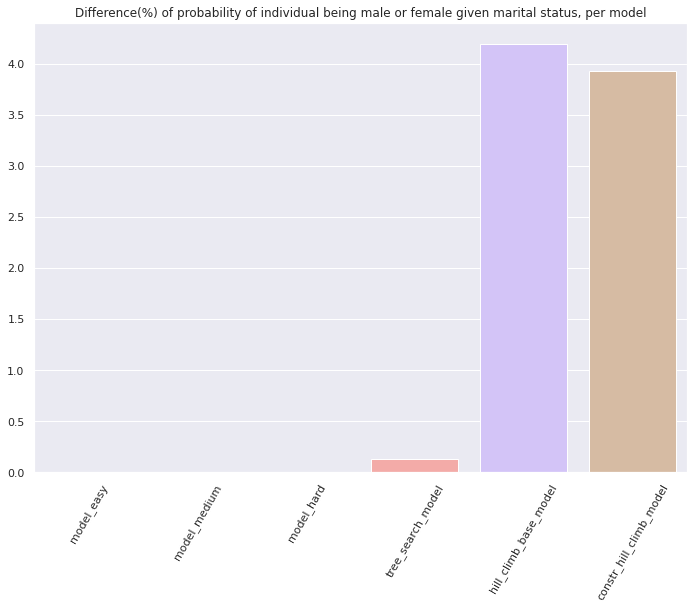

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.xticks(rotation=60)
inference_df = inference_score('Difference(%) of probability of individual being male or female given marital status, per model', ['sex'], ['marriage'])
sns.barplot(x = list(inference_df.keys()), y=list(inference_df.values()) , palette='pastel').set(title='Difference(%) of probability of individual being male or female given marital status, per model')


We can see from the plot that sex is not influenced by marriage status in the hard-coded networks and instead in the networks learned from data we see that the probability of sex given married or not married status changes by around 0.1% for the Tree Search model and around 4% for the Hill Climb ones. 

There is an explanation for this. Indeed, for the network learned from data there is an active trail from marriage node to sex node given marriage. Instead for the hard-coded ones the marriage and sex nodes are part of a v-structure, in which they are both parents. Hence the nodes sex and marriage are independent of one another if the common child is not given in the evidence (as mentioned before in the network analysis), which is the case here. 

If limit_bal was given as evidence, we would however see a difference in the query.

[Text(0.5, 1.0, 'Difference(%) of probability of individual being male or female given marital status and limit_bal, per model')]

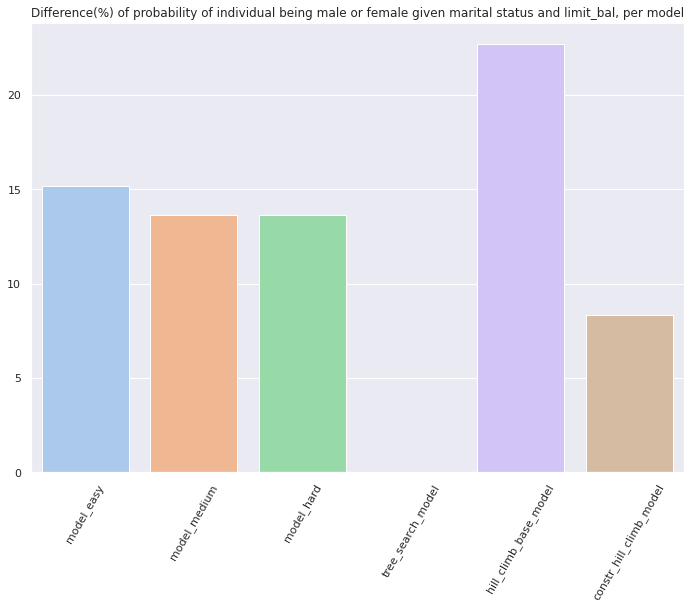

In [ ]:
def inference_score_given_limit_bal(query_desc: str, query: list, evidence: list):
  evidence_values = dataset[evidence[0]].unique()
  data_infer_model = [[model_easy, 'model_easy'], [model_medium, 'model_medium'], [model_hard, 'model_hard'], [tree_search_model, 'tree_search_model'], [hill_climb_base_model, 'hill_climb_base_model'], [constr_hill_climb_model, 'constr_hill_climb_model']]
  impact_on_model = {}
  for model in data_infer_model:
    result = []
    data_infer = VariableElimination(model[0])
    for value in evidence_values:
      result.append(data_infer.query(query, {evidence[0]: value, 'limit_bal': 'low'}).values[0])
    impact_on_model[model[1]] = (max(result) - min(result))/((max(result) + min(result)) / 2) * 100
  return impact_on_model

sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.xticks(rotation=60)
inference_given_limit_bal_df = inference_score_given_limit_bal('Difference(%) of probability of individual being male or female given marital status and limit_bal, per model', ['sex'], ['marriage'])
sns.barplot(x = list(inference_given_limit_bal_df.keys()), y=list(inference_given_limit_bal_df.values()) , palette='pastel').set(title='Difference(%) of probability of individual being male or female given marital status and limit_bal, per model')


We indeed see that given limit_bal we have a change in probability of sex given marital status and limit_bal. Moreover, we see that given limit_bal, there is no change in the Tree Search model - this is because in the Tree Search model sex, limit_bal and marriage are in cascade, and limit_bal is a child node of marriage and a parent node of sex. 

We notice here that probility of guessing the sex of an individual given other attributes seems to be varying quite a lot depending on the model.
Given that this data represents very sensitive financial data, we want to avoid any sort of bias against sex and it seems as if the networks have different bias intrinsic to their structure.  

[Text(0.5, 1.0, 'Difference(%) of probability of default given an individual being male or female, per model')]

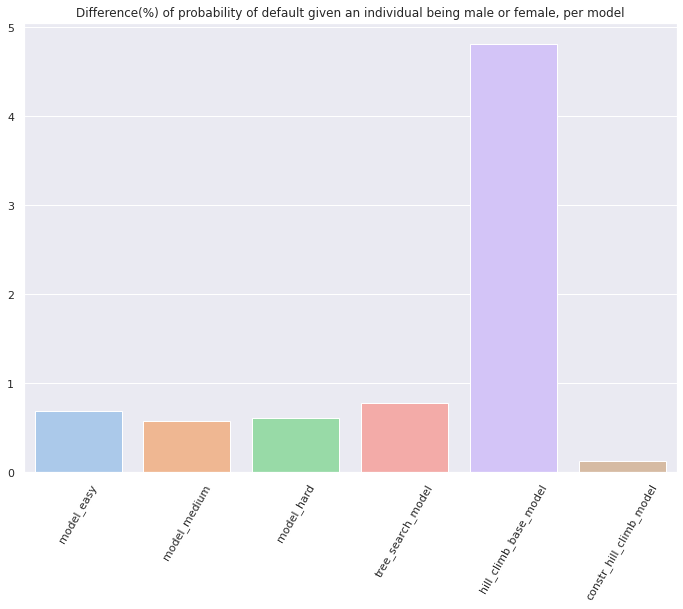

In [ ]:
pd.DataFrame.from_dict(inference_score('How much is default impacted by sex?', ["default"], ['sex']), orient='index')

#This reiterates that it's important to add constraits to a network learned by data as it obviously doesn't take in cosideration the context of the data itself. 
#The constraint_hill_climb model is the model that has the least bias towards sex, as sex has the lowest impact on

sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.xticks(rotation=60)
inference_df = inference_score('Difference(%) of probability of individual being male or female given marital status and limit_bal, per model', ['default'], ['sex'])
sns.barplot(x = list(inference_df.keys()), y=list(inference_df.values()) , palette='pastel').set(title='Difference(%) of probability of default given an individual being male or female, per model')


We can see that hill_climb_base_model_ seems to be heavily biased against sex, in particular probability of credit card default is heavily influenced by sex. 

# Quantitative model evalution
So far, the models have been evaluated only in a qualitative manner. In particular, a domain expert can reasonably tell if the results are good enough. 
The next step is to evaluate the model quantitatively. Since the dataset was created for the classification task, we have leveraged the test set to obtain accuracy, F1/F2, precision, and recall metrics.

In [ ]:
def predict(data_point: dict, inference_object: VariableElimination, query: str) -> tuple[float, float]:
  result = inference_object.query(variables=['default'], evidence=dict(data_point))
  values = result.state_names[query]
  default = np.argmax(result.values)
  return default, result.values # outcome, classes probs

def predict_batch(batch: pd.DataFrame, inference_object: VariableElimination, query: str) -> list[int]:
  return [predict(data_point[1], inference_object, query)[0] for data_point in batch.iterrows()]

In [ ]:
metrics = {model_name: None for model_name in models}

for model_name in metrics:
  preds = predict_batch(X_test, VariableElimination(models[model_name]), query = 'default')
  metrics[model_name] = {'accuracy': accuracy_score(y_test, preds), 
                         'recall': recall_score(y_test, preds), 
                         'f1_score': f1_score(y_test, preds)}
  print_bold(model_name)
  for metric, value in metrics[model_name].items():
    print(f'{metric}: {value:.2%}')

model_easy
accuracy: 80.23%
recall: 28.26%
f1_score: 38.74%
model_medium
accuracy: 80.20%
recall: 29.84%
f1_score: 40.00%
model_hard
accuracy: 79.82%
recall: 27.05%
f1_score: 37.22%
tree_search_model
accuracy: 80.45%
recall: 33.84%
f1_score: 43.36%
hill_climb_base_model
accuracy: 80.20%
recall: 29.24%
f1_score: 39.51%
constr_hill_climb_model
accuracy: 80.23%
recall: 28.26%
f1_score: 38.74%


## Are these results statistically different?
There are no differences among all models, setting the parameter $c$ (i.e. confidence score) to 95% (i.e. $\alpha=0.05$). The function `compare_two_models` outputs a range $[a, b]$. 

In particular, if 0 $\in [a,b]$, there is no statistical difference between the models with confidence $c$.

In [ ]:
def diff_interval(a1, a2, N1, N2, Z):
    d = abs(a1 - a2)
    sd = np.sqrt(a1 * (1-a1) / N1 + a2 * (1-a2) / N2)
    return d - Z * sd, d + Z * sd

def compare_two_models(score1: float, score2: float, len_dataset, c: float = 0.95):
    Z = norm.ppf((1 + c) / 2)
    return diff_interval(score1, score2, len_dataset, len_dataset, Z)

[Text(182.54515, 0.5, 'Models'), Text(0.5, 50.02374999999999, 'Models')]

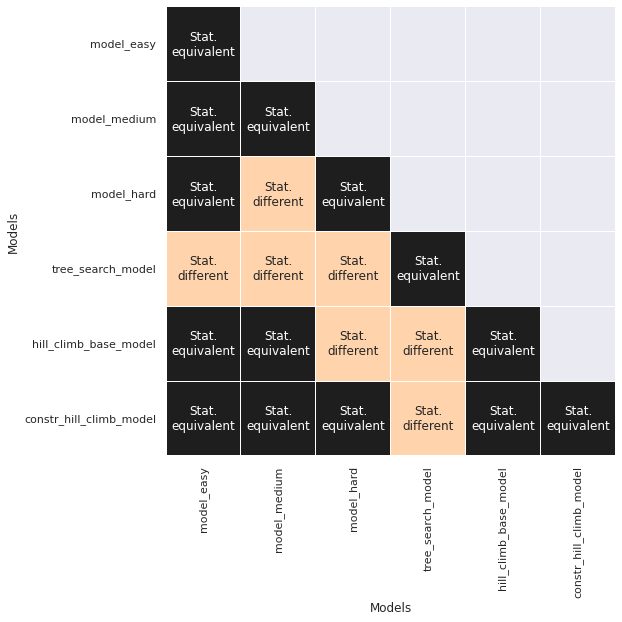

In [ ]:
comparison = np.empty((len(models), len(models)))

for i, model_name in enumerate(metrics):
  for j, inner_model_name in enumerate(metrics):
    range = compare_two_models(metrics[model_name]['f1_score'], metrics[inner_model_name]['f1_score'], len(X_test))
    comparison[i][j] = 0 if range[0] < 0 else 1

print_in_cell = lambda *values: '\n'.join([*values])

sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.heatmap(comparison, \
                annot = np.array([[print_in_cell('Stat.', 'equivalent') if item == 0 else print_in_cell('Stat.', 'different') for item in row ] for row in comparison]), \
                xticklabels=models, yticklabels=models, mask=np.triu(np.ones_like(comparison, dtype=bool), k=1), \
                fmt='', center=0, square=True, linewidths=.5, cbar_kws={'shrink': .5}, cbar=False)
ax.set(xlabel='Models', ylabel='Models')

## Further metrics

In [ ]:
for model_name in models:
  print(f"Correlation score of {model_name}")
  print(correlation_score(models[model_name], dataset))

for model in models:
  print(f"Log Likelihood score of {model_name}")
  print(log_likelihood_score(models[model_name], dataset))

for model in models:
  print(f"Structure score of {model_name}")
  print(structure_score(models[model_name], dataset))

Correlation score of model_easy
0.16666666666666669
Correlation score of model_medium
0.2222222222222222
Correlation score of model_hard
0.2222222222222222
Correlation score of tree_search_model
0.0
Correlation score of hill_climb_base_model
0.0
Correlation score of constr_hill_climb_model
0.0
Log Likelihood score of constr_hill_climb_model
-176670.0695828944
Log Likelihood score of constr_hill_climb_model
-176670.0695828944
Log Likelihood score of constr_hill_climb_model
-176670.0695828944
Log Likelihood score of constr_hill_climb_model
-176670.0695828944
Log Likelihood score of constr_hill_climb_model
-176670.0695828944
Log Likelihood score of constr_hill_climb_model
-176670.0695828944
Structure score of constr_hill_climb_model
-177513.4636136824
Structure score of constr_hill_climb_model
-177513.4636136824
Structure score of constr_hill_climb_model
-177513.4636136824
Structure score of constr_hill_climb_model
-177513.4636136824
Structure score of constr_hill_climb_model
-177513.4636